In [1]:
import triton
import torch
import os
import triton.language as tl
import cutlass
import cutlass.cute as cute
from cutlass.cute.runtime import from_dlpack


DEVICE = torch.device("cuda:0")

In [2]:
# Here we define the torch code

def torch_add(x, y):
    return x + y

In [3]:
# Here we define the torch compile code

@torch.compile
def torch_compile_add(x, y):
    return x + y

In [4]:
# Here we define the triton code

@triton.jit
def add_kernel(x_ptr,
               y_ptr,
               output_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask = mask)
    y = tl.load(y_ptr + offsets, mask = mask)
    z = x + y
    tl.store(output_ptr + offsets, z, mask = mask)

def triton_add(x, y):
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output

In [5]:
# Here we define the cute code

os.environ["PYTHONUNBUFFERED"] = "1"

@cute.kernel
def vectorized_elementwise_add_kernel(
    gA: cute.Tensor,
    gB: cute.Tensor,
    gC: cute.Tensor,
):
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()
    bdim, _, _ = cute.arch.block_dim()

    thread_idx = bidx * bdim + tidx

    # Map logical index to physical address via tensor layout
    a_val = gA[thread_idx]
    b_val = gB[thread_idx]

    # Perform element-wise addition
    gC[thread_idx] = a_val + b_val

@cute.jit
def vectorized_elementwise_add(
    mA: cute.Tensor,
    mB: cute.Tensor,
    mC: cute.Tensor
):
    block_size = 1024
    vectorized_elementwise_add_kernel(mA, mB, mC).launch(
        grid=(cute.size(mC, mode=[0]) // block_size, 1, 1),
        block=(block_size, 1, 1),
    )

a = torch.randn(2048, device="cuda", dtype=torch.float32)
b = torch.randn(2048, device="cuda", dtype=torch.float32)
c = torch.zeros(2048, device="cuda", dtype=torch.float32)
a_ = from_dlpack(a, assumed_align=16).mark_layout_dynamic()
b_ = from_dlpack(b, assumed_align=16).mark_layout_dynamic()
c_ = from_dlpack(c, assumed_align=16).mark_layout_dynamic()
cute_dsl_add_compiled = cute.compile(vectorized_elementwise_add, a_, b_, c_)

def cute_dsl_add(x, y):
    out = torch.zeros_like(x)
    cute_x = from_dlpack(x, assumed_align=16).mark_layout_dynamic()
    cute_y = from_dlpack(y, assumed_align=16).mark_layout_dynamic()
    cute_out = from_dlpack(out, assumed_align=16).mark_layout_dynamic()
    cute_dsl_add_compiled(cute_x, cute_y, cute_out)
    return out


In [6]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'torch_compile', 'cute_dsl'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'Torch Compile', 'Cute dsl'],  # Label name for the lines.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    target_function = globals()[provider + "_add"]
    z = target_function(x, y)
    if torch.norm(z - (x + y)) > 1e-7 :
        print(provider, torch.norm(z - (x + y)), x.shape)
        print(z)
        print(x + y)

    ms, min_ms, max_ms = triton.testing.do_bench(lambda: target_function(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

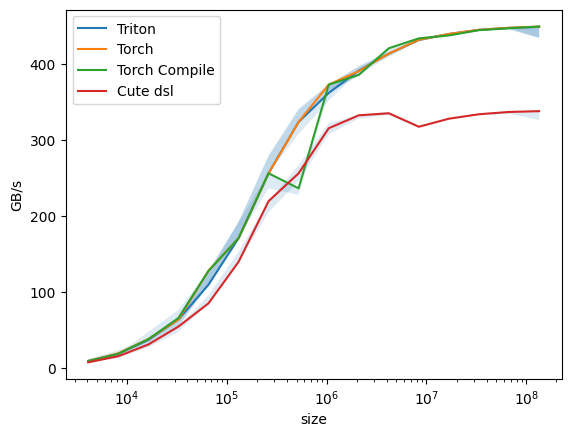

vector-add-performance:
           size      Triton       Torch  Torch Compile    Cute dsl
0        4096.0    9.600000    9.600000       9.600000    8.000000
1        8192.0   19.200000   19.755627      19.200000   15.999999
2       16384.0   37.349544   38.400001      38.400001   31.346939
3       32768.0   63.999998   63.999998      66.064514   54.857142
4       65536.0  109.714284  127.999995     127.999995   85.333330
5      131072.0  170.666661  170.666661     170.666661  139.636363
6      262144.0  255.999991  255.999991     255.999991  219.428568
7      524288.0  323.368435  323.368435     236.307695  255.999991
8     1048576.0  361.411758  372.363633     372.363633  315.076934
9     2097152.0  390.870784  390.095241     385.128315  332.108094
10    4194304.0  413.042029  413.042029     420.102553  334.794387
11    8388608.0  430.980686  431.157886     433.057275  317.109674
12   16777216.0  438.857137  438.857137     436.906674  327.679984
13   33554432.0  444.264798  444.31187

In [7]:
benchmark.run(print_data=True, show_plots=True)